### 方法(制約付きサンプリング)
```
while 調べるべき特徴量がある限り :
    for 調べる特徴量 in 調べる特徴量の数 :
        ある特徴量ベクトルxiと元のy(y^)の内積を求める(t^i)
        for 100程度 :
            y^を、{t0 = t^0かつt1 = t^1...tj = t^j}という条件の元サンプリング（nealを使う）しyを生成する。
            ある特徴量ベクトルxiとyの内積を求める(ti)
        複数のtiを求めることによって得られた分布に対するt^iの位置から、p値を求める。
    p値の一番小さいXs[交絡因子]を知る。
    条件{}にts = t^sを足す（更新する）
    調べる特徴量からXsを除外（更新する）
```
<br/>

#### **交絡因子とexact logistic regression**
交絡因子を除いたあと、p値を求めその値が大きかったとき、交絡因子はデータに対して大きく相関していたということがわかる。

### 条件について
- t0 = t^0 : 1の総和が同じ
- tj = t^j : xの特徴量jつ目とyの内積の値が同じ


### yのサンプリング
- コンパイルを行うまでは`pyqubo`
- SAは`SimulatedAnnealingSampler()`

### 改訂(08/03)
- ori_tiのkeyがなかった場合に1とする必要がない
- sum([j[1] for j in ti_list])は必ず100である

### 改訂（08/04）
- numreads=100を使用

In [84]:
#!pip3 install dwave-neal

In [85]:
import pandas as pd 
import numpy as np
from neal import SimulatedAnnealingSampler
from pyqubo import Array, Constraint, Placeholder, solve_qubo

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt

In [87]:
X_mushroom = pd.read_csv("../input/SNP_df1010.csv", sep=',', index_col=0)
y_mushroom = pd.read_csv('../input/y10.csv', sep=',', index_col=0)['y']

num_samples = X_mushroom.shape[0]
num_cols = X_mushroom.shape[1]
columns = list(X_mushroom.columns)

y_sum = sum(y_mushroom)

In [88]:
num_samples

10

In [89]:
y_sum

6

#### to_quboでのトライアル（t^0だけ）

In [90]:
y = Array.create('y', shape=num_samples, vartype='BINARY')

#QUBO式で定式化
H = (sum(y) - y_sum)**2
qb = H.compile().to_qubo()
sa_sampler = SimulatedAnnealingSampler()
res = sa_sampler.sample_qubo(qb[0], num_reads=100)

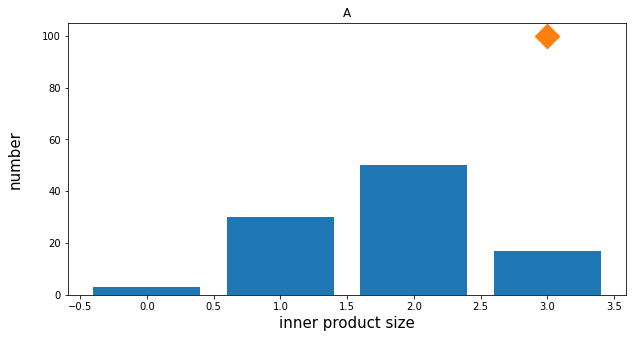

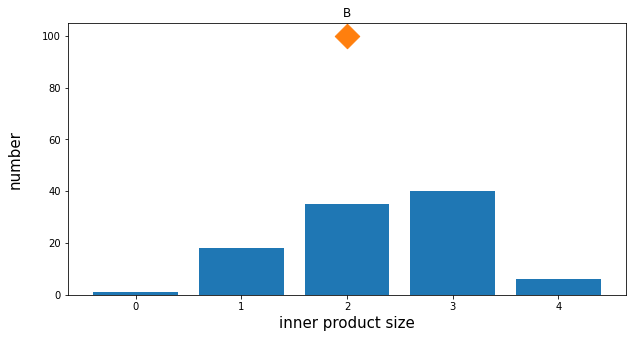

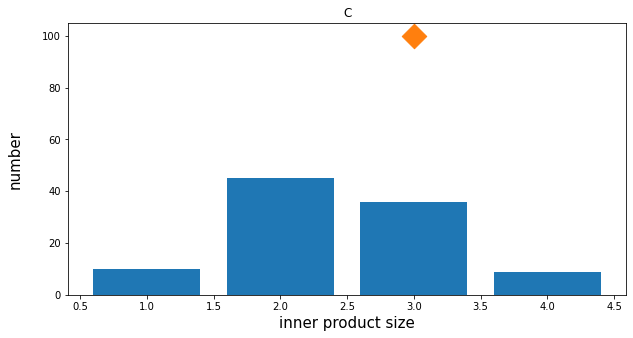

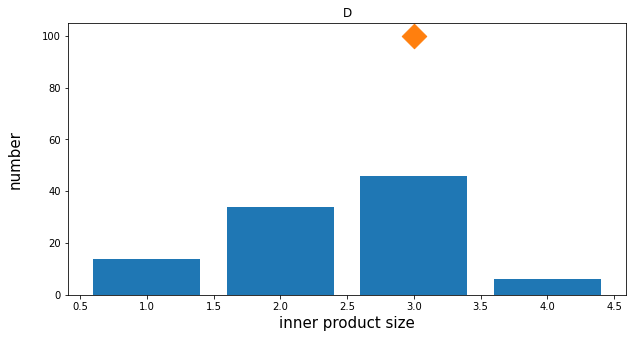

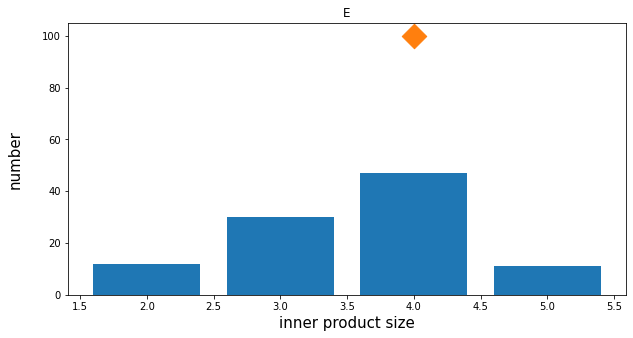

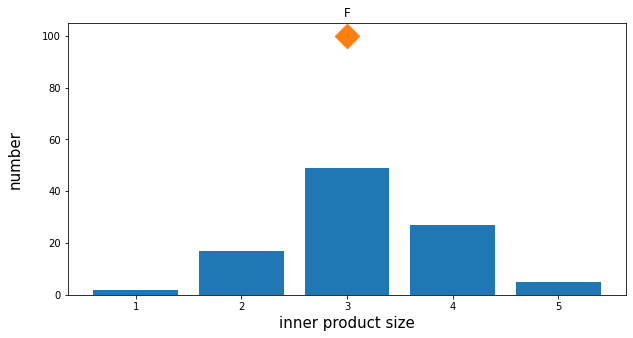

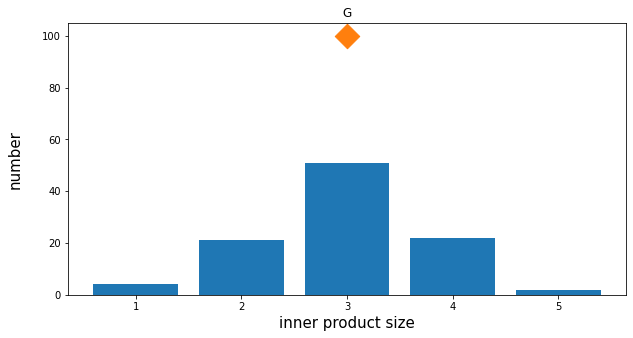

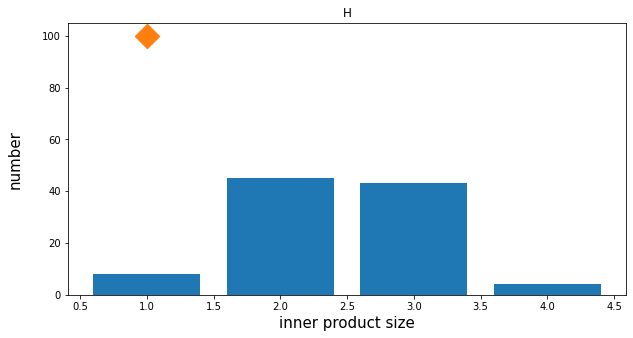

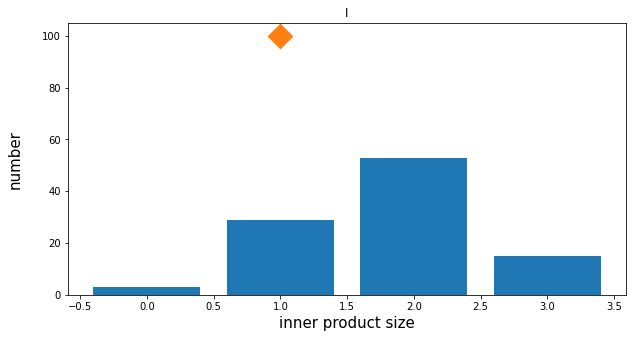

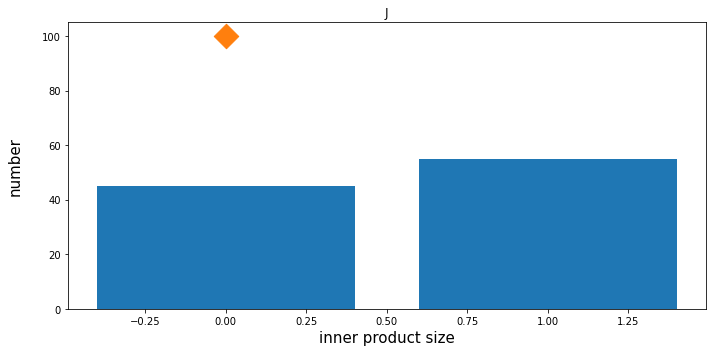

In [92]:
bqm_minP_cols = []
servey_num_col_list = columns

p = {}
for i in servey_num_col_list:
    ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp

    ti_dic = {} #{内積の値:該当数}という辞書。

    for y_info in list(res.record):
        y = pd.Series(y_info[0])

        if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
            ti_dic[int(np.dot(X_mushroom[i], y))] += 1
        else:
            ti_dic[int(np.dot(X_mushroom[i], y))] = 1

    ti_list = sorted(ti_dic.items()) #listになり、要素はタプルになる。
    franc = sum([j[1] for j in ti_list if j[0] >= ori_ti])
    p[i] = franc/100
    
    # ヒストグラムを出力
    plt.figure(figsize=(10, 5))
    plt.title(i) 
    plt.bar([j[0] for j in ti_list], [j[1] for j in ti_list])
    plt.xlabel('inner product size', fontsize=15)
    plt.ylabel('number', rotation=90, fontsize=15, labelpad=20)
    plt.scatter(ori_ti, 100, s=300, marker='D')

#図が重ならないようにする
plt.tight_layout()

#図を表示
plt.show()

#### to_dimod_bqmでのトライアル（t^0だけ）

In [93]:
y = Array.create('y', shape=num_samples, vartype='BINARY')

#QUBO式で定式化
H = (sum(y) - y_sum)**2
bqm = H.compile().to_dimod_bqm()
sa_sampler = SimulatedAnnealingSampler()
res = sa_sampler.sample(bqm, num_reads=100)

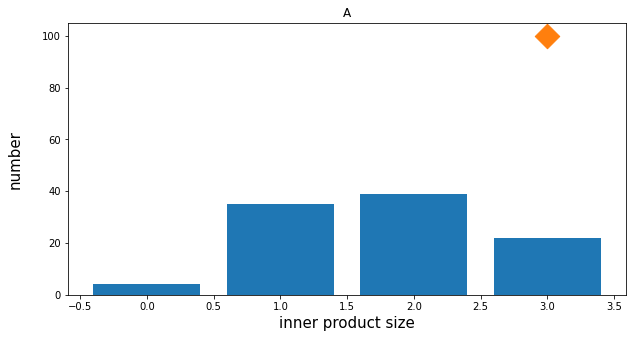

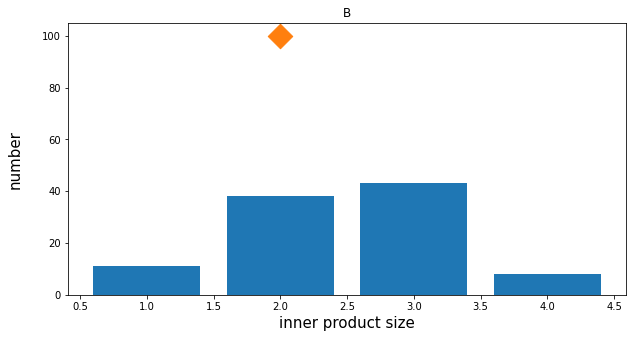

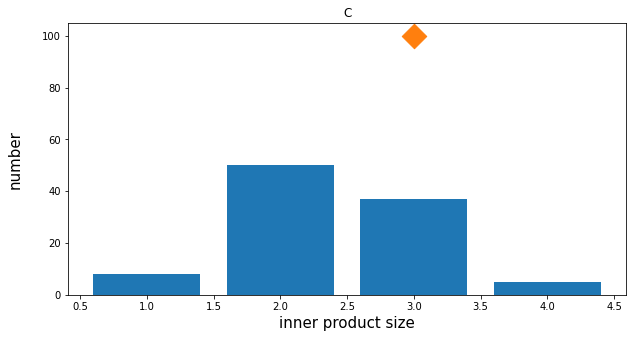

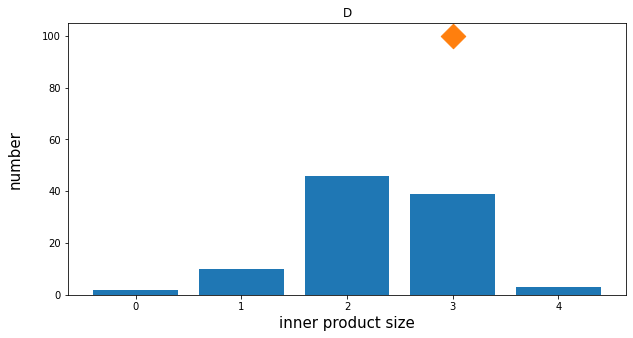

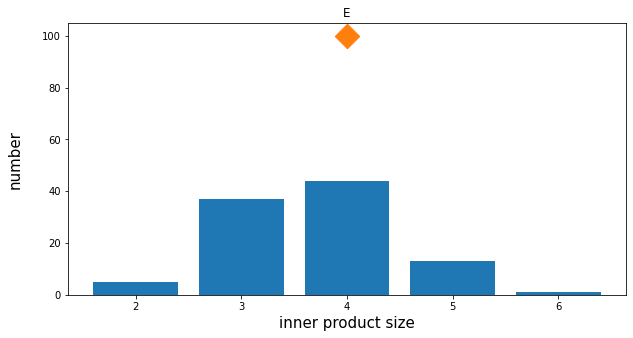

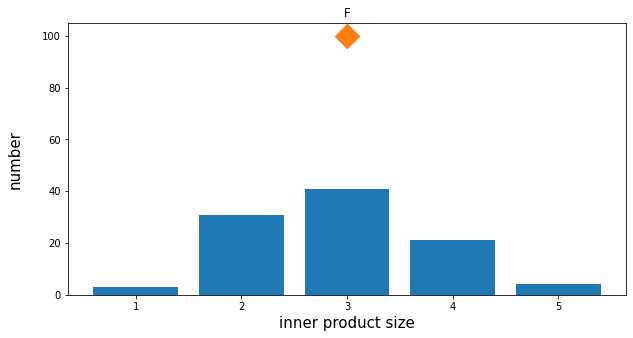

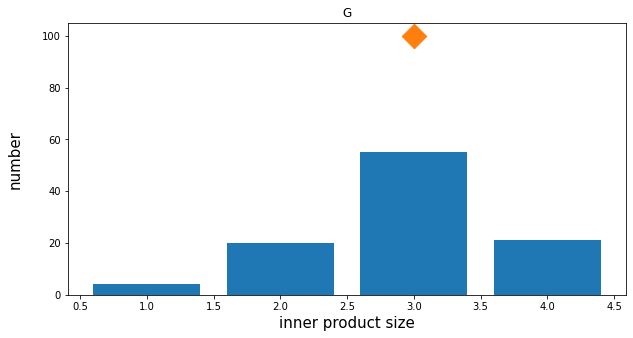

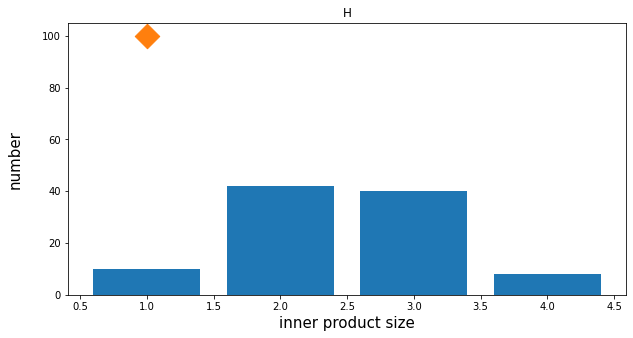

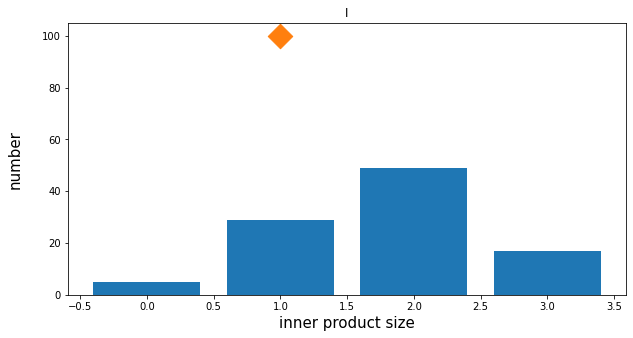

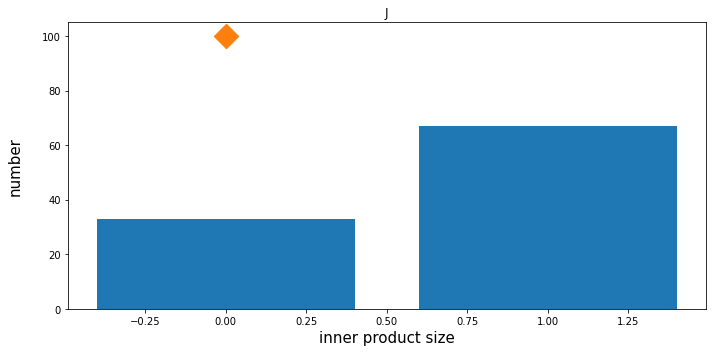

In [94]:
bqm_minP_cols = []
servey_num_col_list = columns

p = {}
for i in servey_num_col_list:
    ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp

    ti_dic = {} #{内積の値:該当数}という辞書。

    for y_info in list(res.record):
        y = pd.Series(y_info[0])

        if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
            ti_dic[int(np.dot(X_mushroom[i], y))] += 1
        else:
            ti_dic[int(np.dot(X_mushroom[i], y))] = 1

    ti_list = sorted(ti_dic.items()) #listになり、要素はタプルになる。
    franc = sum([j[1] for j in ti_list if j[0] >= ori_ti])
    p[i] = franc/100
    
    # ヒストグラムを出力
    plt.figure(figsize=(10, 5))
    plt.title(i) 
    plt.bar([j[0] for j in ti_list], [j[1] for j in ti_list])
    plt.xlabel('inner product size', fontsize=15)
    plt.ylabel('number', rotation=90, fontsize=15, labelpad=20)
    plt.scatter(ori_ti, 100, s=300, marker='D')

#図が重ならないようにする
plt.tight_layout()

#図を表示
plt.show()

### 全体

In [80]:
def SA_qb_y(minP_cols):
    # BINARY変数
    y = Array.create('y', shape=num_samples, vartype='BINARY')

    #QUBO式で定式化
    H = (sum(y) - y_sum)**2

    if len(minP_cols) > 0:
        for i in minP_cols:
            H_plus = (np.dot(X_mushroom[i], y) - np.dot(X_mushroom[i], y_mushroom))**2
            H = H + H_plus

    qb = H.compile().to_qubo()

    sa_sampler = SimulatedAnnealingSampler()

    res = sa_sampler.sample_qubo(qb[0], num_reads=100)
    
    return list(res.record)

In [81]:
def SA_bqm_y(minP_cols):
    # BINARY変数
    y = Array.create('y', shape=num_samples, vartype='BINARY')
    
    #QUBO式で定式化
    H = (sum(y) - y_sum)**2
    
    if len(minP_cols) > 0:
        for i in minP_cols:
            H_plus = (np.dot(X_mushroom[i], y) - np.dot(X_mushroom[i], y_mushroom))**2
            H = H + H_plus
    
    bqm = H.compile().to_dimod_bqm()

    sa_sampler = SimulatedAnnealingSampler()
    
    res = sa_sampler.sample(bqm, num_reads=100)

    return list(res.record)

In [73]:
bqm_minP_cols = []
servey_num_col_list = columns
distri_element_num = 100

while len(servey_num_col_list) > 0:    
    p = {}
    for i in servey_num_col_list:
        ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp
        
        ti_dic = {} #{内積の値:該当数}という辞書。
        
        res_record = SA_bqm_y(minP_cols)
        for y_info in res_record:
            y = pd.Series(y_info[0])
            
            if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
                ti_dic[int(np.dot(X_mushroom[i], y))] += 1
            else:
                ti_dic[int(np.dot(X_mushroom[i], y))] = 1
                
        count_better_t = sum([v for k, v in ti_dic.items() if k >= ori_ti])
        p[i] = count_better_t / distri_element_num

        
    bqm_minP_keys = [k for k, v in p.items() if v == min(list(p.values()))]
    print(bqm_minP_keys)
    bqm_minP_cols += bqm_minP_keys
    servey_num_col_list = [i for i in servey_num_col_list if i not in bqm_minP_keys]

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


In [74]:
bqm_minP_cols #['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

In [82]:
qb_minP_cols = []
servey_num_col_list = columns
distri_element_num = 100

while len(servey_num_col_list) > 0:    
    p = {}
    for i in servey_num_col_list:
        ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp
        
        ti_dic = {} #{内積の値:該当数}という辞書。
        
        res_record = SA_qb_y(minP_cols)
        for y_info in res_record:
            y = pd.Series(y_info[0])
            
            if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
                ti_dic[int(np.dot(X_mushroom[i], y))] += 1
            else:
                ti_dic[int(np.dot(X_mushroom[i], y))] = 1
                
        count_better_t = sum([v for k, v in ti_dic.items() if k >= ori_ti])
        p[i] = count_better_t / distri_element_num

        
    qb_minP_keys = [k for k, v in p.items() if v == min(list(p.values()))]
    print(bqm_minP_keys)
    qb_minP_cols += qb_minP_keys
    servey_num_col_list = [i for i in servey_num_col_list if i not in qb_minP_keys]

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


In [83]:
qb_minP_cols #['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

In [ ]:
'''
minP_cols = []
servey_num_col_list = columns

while len(servey_num_col_list) > 0:    
    p = {}
    for i in servey_num_col_list:
        ori_ti = int(np.dot(X_mushroom[i], y_mushroom)) #特徴量iを表すp
        
        ti_dic = {} #分布の要素となる値を格納する
        for _ in range(100): 
            y = make_y(minP_cols)
            
            if int(np.dot(X_mushroom[i], y)) in ti_dic.keys():
                ti_dic[int(np.dot(X_mushroom[i], y))] += 1
            else:
                ti_dic[int(np.dot(X_mushroom[i], y))] = 1
                
        bunshi = sum([ti_dic[ii] for ii in range(ori_ti, int(list(ti_dic.keys())[-1])+1)])
        p[i] = bunshi/sum(list(ti_dic.values()))
        
    minP_keys = [k for k, v in p.items() if v == min(list(p.values()))]
    minP_cols += minP_keys
    servey_num_col_list = [i for i in servey_num_col_list if i not in minP_keys]
    
#minP_cols #['A', 'D', 'G', 'I', 'C', 'F', 'E', 'B', 'H', 'J']
'''

In [ ]:
'''
if not ori_ti in ti_dic.keys():
    ti_dic[ori_ti] = 1                        
ti_list = sorted(ti_dic.items()) #listになり、要素はタプルになる。
franc = sum([j[1] for j in ti_list if j[0] >= ori_ti])
denomi = sum([j[1] for j in ti_list])
p[i] = franc/denomi

↓

count_better_t = sum([v for k, v in ti_dic.items() if k >= ori_ti])
p[i] = count_better_t / distri_element_num


結果
#minP_cols #['A', 'D', 'F', 'I', 'E', 'G', 'C', 'B', 'H', 'J']
'''

In [ ]:
'''
def make_y(minP_cols):
    # BINARY変数
    y = Array.create('y', shape=num_samples, vartype='BINARY')
    
    #QUBO式で定式化
    H = (sum(y) - y_sum)**2
    
    if len(minP_cols) > 0:
        for i in minP_cols:
            H_plus = (np.dot(X_mushroom[i], y) - np.dot(X_mushroom[i], y_mushroom))**2
            H = H + H_plus
    
    bqm = H.compile().to_dimod_bqm()

    sa_sampler = SimulatedAnnealingSampler()
    
    res = sa_sampler.sample(bqm, num_reads=100)

    return list(res.record)
    
結果
#minP_cols #['A', 'D', 'F', 'I', 'E', 'G', 'C', 'B', 'H', 'J']
'''